# Frequency response — drone

This notebook makes use of interactive plots (i.e., plots that allow you to zoom in) that are enabled with the following command:
```python
%matplotlib widget
```

If you want to use interactive plots, you must have `ipympl` installed in your conda environment. If you have not already done so, you can install it by running the following command in a terminal (with the `ae353` environment active):
```zsh
conda install ipympl
```

## Setup

Import modules.

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

import ae353_dronecontrol # <--- has a working controller for the purpose of demonstration

import sympy as sym
from scipy import linalg
from matplotlib.ticker import MultipleLocator
from IPython.display import display, Latex, Markdown

# Stupid hack because tornado is broken in jupyter
%matplotlib widget
# plt.ioff()
# plt.ion()

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

pybullet build time: Sep  3 2024 12:57:43


Create and print a seed for the random number generator so it is possible to reproduce the results. Here are a few best practices:

* By default, keep this code unchanged.
* When producing final results for your report, (1) run this cell once to create a seed, (2) copy/paste this seed into the line of code that creates a simulator, and (3) replace the code cell that creates a seed with a markdown cell saying that you took this approach to choose a seed for testing.

In [2]:
seed = secrets.randbits(32)
print(seed)

3268220780


Create simulator with seed.

In [3]:
simulator = ae353_drone.Simulator(seed=seed)

argv[0]=


Add a camera view. This view will be displayed in its own browser window.

In [4]:
simulator.add_view(
    'my_start_view',  # name of view (must be unique)
    'start',          # type of view (start, top, right, left, or back)
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


Do not check for inactivity.

In [5]:
simulator.set_rules(error_on_inactive=False)

Define functions to show results.

In [6]:
def show_matrix(key, val):
    latex = sym.latex(sym.nsimplify(sym.Matrix(val), rational=True))
    display(Markdown(f'$${key} = {latex}$$'))
    
def show_transfer_function(key, val):
    latex = sym.latex(sym.nsimplify(val, rational=True))
    display(Markdown(f'$${key}(s) = {latex}$$'))

Choose amplitude and period of oscillation.

In [7]:
a = 0.05
T = 5.

Create controller.

In [8]:
class DemoController(ae353_dronecontrol.Controller):
    def get_xdes(self, t, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
        xdes = np.zeros(12)
        xdes[0:3] = np.array([0., 0., 1.])
        
        omega = (2 * np.pi / T)
        xdes[1] += a * np.sin(omega * t)
        
        return xdes

Clear all drones.

In [9]:
simulator.clear_drones()

Add drone to simulator.

In [10]:
simulator.add_drone(DemoController, 'template', 'template.png')

Reset the drone with a hard-coded initial condition and zero sensor noise for the purpose of demonstration.

In [11]:
simulator.reset(
    initial_conditions={
        'template': {
            'p_x': 0.,
            'p_y': 0.,
            'p_z': 1.,
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
            'v_x': 0.,
            'v_y': 0.,
            'v_z': 0.,
            'w_x': 0.,
            'w_y': 0.,
            'w_z': 0.,
            'p_x_meas': 0.,
            'p_y_meas': 0.,
            'p_z_meas': 1.,
            'yaw_meas': 0.,
        },
    },
    marker_noise=0.,
)

Run simulation.

In [12]:
# Enable views to run in real-time
simulator.enable_views()

# # Disable views to run as fast as possible
# simulator.disable_views()

simulator.run(max_time=25.)

Get data.

In [20]:
data = simulator.get_data('template')

Get model.

In [13]:
# This is something you can do yourself as well
drone = simulator.get_drone_by_name('template')
controller = drone['controller']

# This is something you cannot do yourself, unless you add
# the function get_model() to your Controller class.
A, B, C, K, L = controller.get_model()

Define a matrix that picks the only element of $x_\text{des}$ that varies.

In [14]:
e_i = np.zeros((12, 1))
e_i[1] = 1.

show_matrix('e_i', e_i)

$$e_i = \left[\begin{matrix}0\\1\\0\\0\\0\\0\\0\\0\\0\\0\\0\\0\end{matrix}\right]$$

Define closed-loop model.

In [15]:
Am = np.block([[A    , -B @ K           ],
               [L @ C, A - B @ K - L @ C]])

Bm = np.block([[B @ K @ e_i],
               [B @ K @ e_i]])

Cm = np.block([[e_i.T, np.zeros((1, A.shape[0]))]])

# These matrices are large and have non-integer elements - here is
# how to show them if we wanted to:
#
#  show_matrix('A_m', Am)
#  show_matrix('B_m', Bm)
#  show_matrix('C_m', Cm)

Define the **transfer function**

$$H(s) = C_m (s - A_m)^{-1} B_m$$

where $s\in\mathbb{C}$ is a complex number.

In [16]:
H = lambda s: (Cm @ linalg.inv(s * np.eye(Am.shape[0]) - Am) @ Bm).item()

Show Bode plot (dB, degrees).

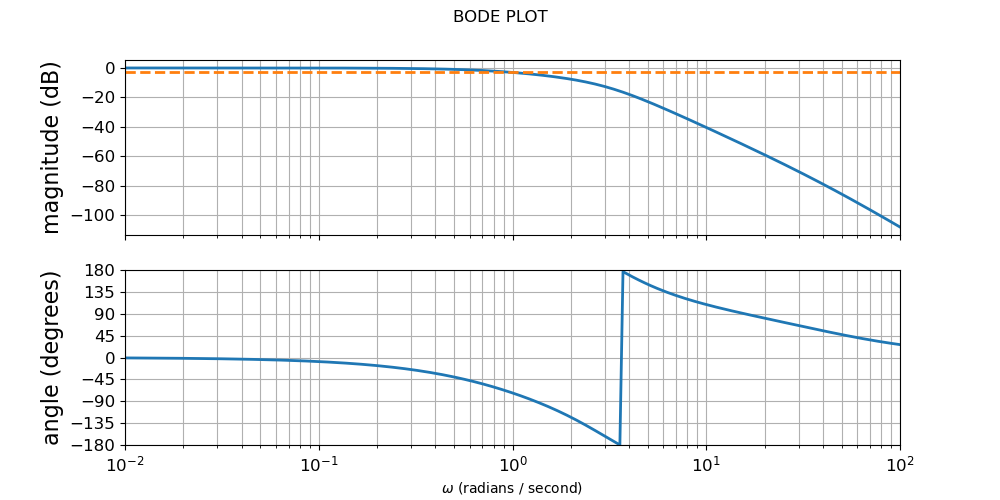

In [17]:
omega = np.logspace(-2, 2, 250)
H_at_jomega = np.empty_like(omega, dtype=complex)
for i in range(len(omega)):
    H_at_jomega[i] = H(1j * omega[i])
mag = np.absolute(H_at_jomega)
ang = np.angle(H_at_jomega)

mag_in_dB = 20. * np.log10(mag)
ang_in_deg = np.rad2deg(ang)

fig, (ax_mag, ax_ang) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax_mag.semilogx(omega, mag_in_dB, linewidth=2)
ax_mag.semilogx(omega, -3. * np.ones_like(omega), '--', linewidth=2)
ax_mag.grid(visible=True, which='both', axis='both')
ax_mag.tick_params(labelsize=12)
ax_mag.yaxis.set_major_locator(MultipleLocator(20))
ax_mag.set_ylabel('magnitude (dB)', fontsize=16)
ax_ang.semilogx(omega, ang_in_deg, linewidth=2)
ax_ang.grid(visible=True, which='both', axis='both')
ax_ang.tick_params(labelsize=12)
ax_ang.yaxis.set_major_locator(MultipleLocator(45))
ax_ang.set_ylabel('angle (degrees)', fontsize=16)
ax_ang.set_ylim([-180, 180])
ax_ang.set_xlim([min(omega), max(omega)])
ax_ang.set_xlabel(r'$\omega$ (radians / second)')
fig.suptitle('BODE PLOT')
plt.show()

Show Bode plot (absolute, radians).

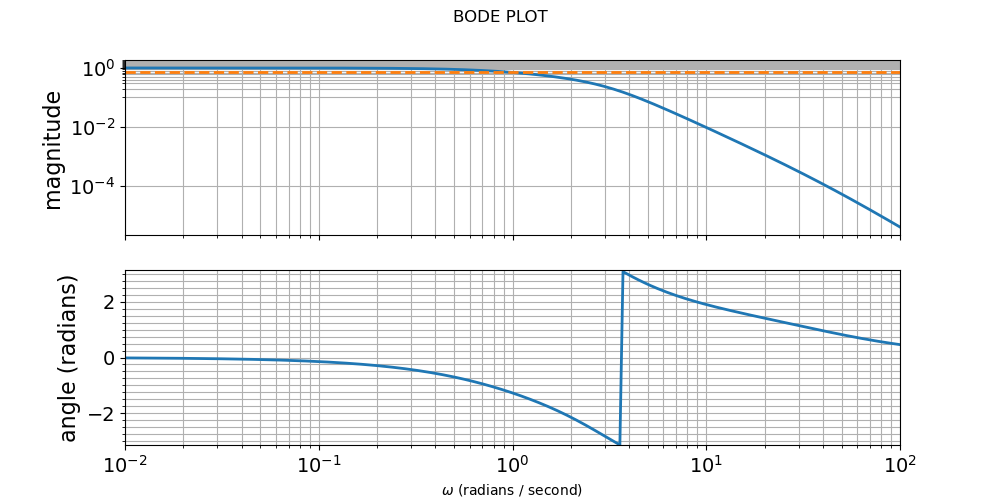

In [18]:
omega = np.logspace(-2, 2, 250)
H_at_jomega = np.empty_like(omega, dtype=complex)
for i in range(len(omega)):
    H_at_jomega[i] = H(1j * omega[i])
mag = np.absolute(H_at_jomega)
ang = np.angle(H_at_jomega)

fig, (ax_mag, ax_ang) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax_mag.loglog(omega, mag, linewidth=2)
ax_mag.loglog(omega, 10**(-3 / 20) * np.ones_like(omega), '--', linewidth=2)
ax_mag.grid(visible=True, which='both', axis='both')
ax_mag.tick_params(labelsize=14)
ax_mag.yaxis.set_minor_locator(MultipleLocator(1e-1))
ax_mag.set_yticklabels([], minor=True)
ax_mag.set_ylabel('magnitude', fontsize=16)
ax_ang.semilogx(omega, ang, linewidth=2)
ax_ang.grid(visible=True, which='both', axis='both')
ax_ang.tick_params(labelsize=14)
ax_ang.yaxis.set_minor_locator(MultipleLocator(0.25))
ax_ang.set_yticklabels([], minor=True)
ax_ang.set_ylabel('angle (radians)', fontsize=16)
ax_ang.set_ylim([-np.pi, np.pi])
ax_ang.set_xlim([min(omega), max(omega)])
ax_ang.set_xlabel(r'$\omega$ (radians / second)')
fig.suptitle('BODE PLOT')
plt.show()

Show results ($p_y$ only).

omega = 1.2566370614359172 (T = 5.000)
H(j omega) = 0.0305-0.6155j
mag = 0.6163
ang = -1.5213


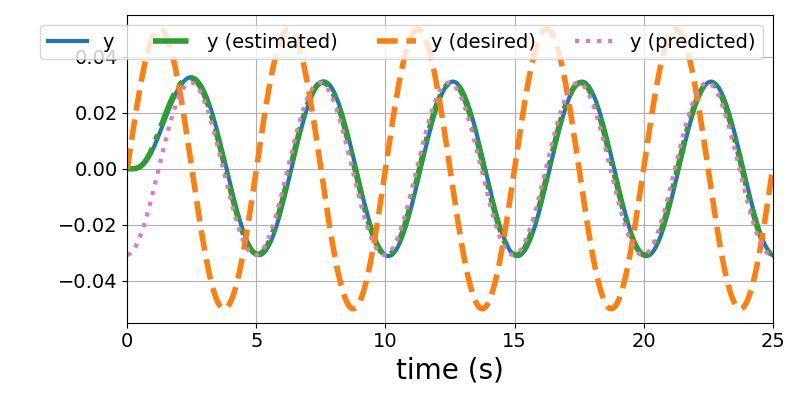

In [21]:
omega = (2 * np.pi) / T
H_of_jomega = H(1j * omega)
magH = np.absolute(H_of_jomega)
angH = np.angle(H_of_jomega)

print(f'omega = {omega} (T = {2 * np.pi / omega:.3f})')
print(f'H(j omega) = {H_of_jomega:.4f}')
print(f'mag = {magH:.4f}')
print(f'ang = {angH:.4f}')

p_y = data['p_y']
p_y_est = data['xhat'][:, 1]
p_y_des = data['xdes'][:, 1]
p_y_pre = data['p_y'][0] + a * magH * np.sin(omega * data['t'] + angH)

# Create a figure with subplots that all share the same x-axis
fig, ax_py = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

ax_py.plot(data['t'], p_y, label='y', linewidth=3, color='C0')
ax_py.plot(data['t'], p_y_est, '-.', label='y (estimated)', linewidth=4, color='C2')
ax_py.plot(data['t'], p_y_des, '--', label='y (desired)', linewidth=4, color='C1')
ax_py.plot(data['t'], p_y_pre, ':', label='y (predicted)', linewidth=3, color='C6')
ax_py.grid()
ax_py.legend(fontsize=14, ncol=4, loc='upper right')
ax_py.tick_params(labelsize=14)
ax_py.set_xlabel('time (s)', fontsize=20)
ax_py.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()